## Problem Statement
### To build a machine learning model that accurately predicts an individual's earnings in 1978 using demographic and prior income features. The goal is to identify key socio-economic factors influencing income and forecast earnings effectively.

###1. Importing  necessary libraries

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.metrics import accuracy_score

###2. Upload and read Dataset

In [2]:
from google.colab import files
uploaded = files.upload()
df=pd.read_csv('LabourTrainingData.csv')

Saving LabourTrainingData.csv to LabourTrainingData.csv


In [4]:
df.head()

,Age,Eduacation,Race,Hisp,MaritalStatus,Nodeg,Earnings_1974,Earnings_1975,Earnings_1978
0,45,LessThanHighSchool,NotBlack,NotHispanic,Married,1,21516.670,25243.550,25564.670
1,21,Intermediate,NotBlack,NotHispanic,NotMarried,0,3175.971,5852.565,13496.080
2,38,HighSchool,NotBlack,NotHispanic,Married,0,23039.020,25130.760,25564.670
3,48,LessThanHighSchool,NotBlack,NotHispanic,Married,1,24994.370,25243.550,25564.670
4,18,LessThanHighSchool,NotBlack,NotHispanic,Married,1,1669.295,10727.610,9860.869


In [5]:
df.rename(columns={"Eduacation": "Education"}, inplace=True)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15992 entries, 0 to 15991
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            15992 non-null  int64  
 1   Education      15992 non-null  object 
 2   Race           15992 non-null  object 
 3   Hisp           15992 non-null  object 
 4   MaritalStatus  15992 non-null  object 
 5   Nodeg          15992 non-null  int64  
 6   Earnings_1974  15992 non-null  float64
 7   Earnings_1975  15992 non-null  float64
 8   Earnings_1978  15992 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 1.1+ MB


In [7]:
df.describe(include='all')

,Age,Education,Race,Hisp,MaritalStatus,Nodeg,Earnings_1974,Earnings_1975,Earnings_1978
count,15992.000000,15992,15992,15992,15992,15992.000000,15992.000000,15992.000000,15992.000000
unique,NaN,5,2,2,2,NaN,NaN,NaN,NaN
top,NaN,HighSchool,NotBlack,NotHispanic,Married,NaN,NaN,NaN,NaN
freq,NaN,6252,14816,14840,11382,NaN,NaN,NaN,NaN
mean,33.225238,NaN,NaN,NaN,NaN,0.295835,14016.800304,13650.803376,14846.659673
std,11.045216,NaN,NaN,NaN,NaN,0.456432,9569.795893,9270.403225,9647.391524
min,16.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
25%,24.000000,NaN,NaN,NaN,NaN,0.000000,4403.452250,4398.823000,5669.298000
50%,31.000000,NaN,NaN,NaN,NaN,0.000000,15123.580000,14557.110000,16421.975000
75%,42.000000,NaN,NaN,NaN,NaN,1.000000,23584.180000,22923.737500,25564.670000


In [8]:
df.isnull().sum()

,0
Age,0
Education,0
Race,0
Hisp,0
MaritalStatus,0
Nodeg,0
Earnings_1974,0
Earnings_1975,0
Earnings_1978,0


###3. Data Preprocessing
####A. Outlier detection using boxplot

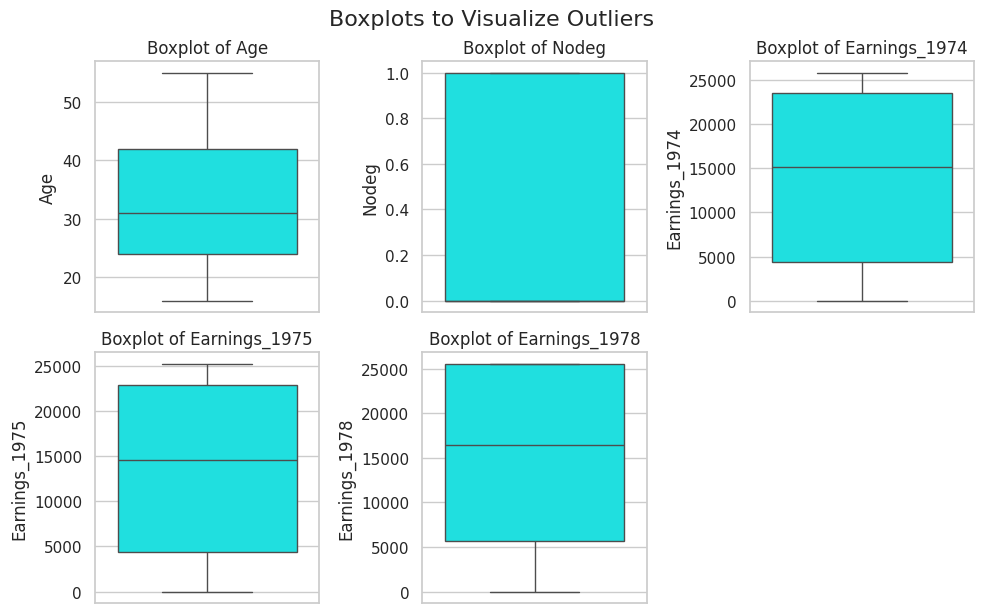

In [9]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, (len(numeric_cols) + 1) // 2, i)
    sns.boxplot(data=df, y=col, color="aqua")
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.suptitle("Boxplots to Visualize Outliers", fontsize=16, y=1.02)
plt.show()

####B. Defining Column categories

In [10]:
numerical_cols = ['Age', 'Earnings_1974', 'Earnings_1975', 'Earnings_1978']
categorical_cols = ['Education', 'Race', 'Hisp', 'MaritalStatus']
binary_cols = ['Nodeg']

In [11]:
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [12]:
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


In [13]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
], remainder='passthrough')

In [14]:
processed_data = preprocessor.fit_transform(df)

In [15]:
ohe_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
final_feature_names = numerical_cols + list(ohe_features) + binary_cols

In [16]:
processed_df = pd.DataFrame(
    processed_data.toarray() if hasattr(processed_data, "toarray") else processed_data,
    columns=final_feature_names
)

In [17]:
processed_df.to_csv("LabourTrainingData_Processed.csv", index=False)

In [18]:
df1 = pd.read_csv("LabourTrainingData_Processed.csv")


In [19]:
df1.head()

,Age,Earnings_1974,Earnings_1975,Earnings_1978,Education_HighSchool,Education_Intermediate,Education_LessThanHighSchool,Education_PostGraduate,Education_graduate,Race_NotBlack,Race_black,Hisp_NotHispanic,Hisp_hispanic,MaritalStatus_Married,MaritalStatus_NotMarried,Nodeg
0,1.066084,0.783727,1.250551,1.111010,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,-1.106870,-1.132853,-0.841224,-0.139999,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.432306,0.942810,1.238384,1.111010,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1.337704,1.147142,1.250551,1.111010,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,-1.378489,-1.290298,-0.315335,-0.516818,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


###4. EDA (Exploratory Data Analysis)

In [20]:
print(df1.info())
print(df1.describe(include='all'))

categorical_cols_encoded = [col for col in df1.columns if 'Education_' in col or 'Race_' in col or 'Hisp_' in col or 'MaritalStatus_' in col]

for col in categorical_cols_encoded + ['Nodeg']:
    print(f"\n{col} Value Counts:\n", df1[col].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15992 entries, 0 to 15991
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Age                           15992 non-null  float64
 1   Earnings_1974                 15992 non-null  float64
 2   Earnings_1975                 15992 non-null  float64
 3   Earnings_1978                 15992 non-null  float64
 4   Education_HighSchool          15992 non-null  float64
 5   Education_Intermediate        15992 non-null  float64
 6   Education_LessThanHighSchool  15992 non-null  float64
 7   Education_PostGraduate        15992 non-null  float64
 8   Education_graduate            15992 non-null  float64
 9   Race_NotBlack                 15992 non-null  float64
 10  Race_black                    15992 non-null  float64
 11  Hisp_NotHispanic              15992 non-null  float64
 12  Hisp_hispanic                 15992 non-null  float64
 13  M

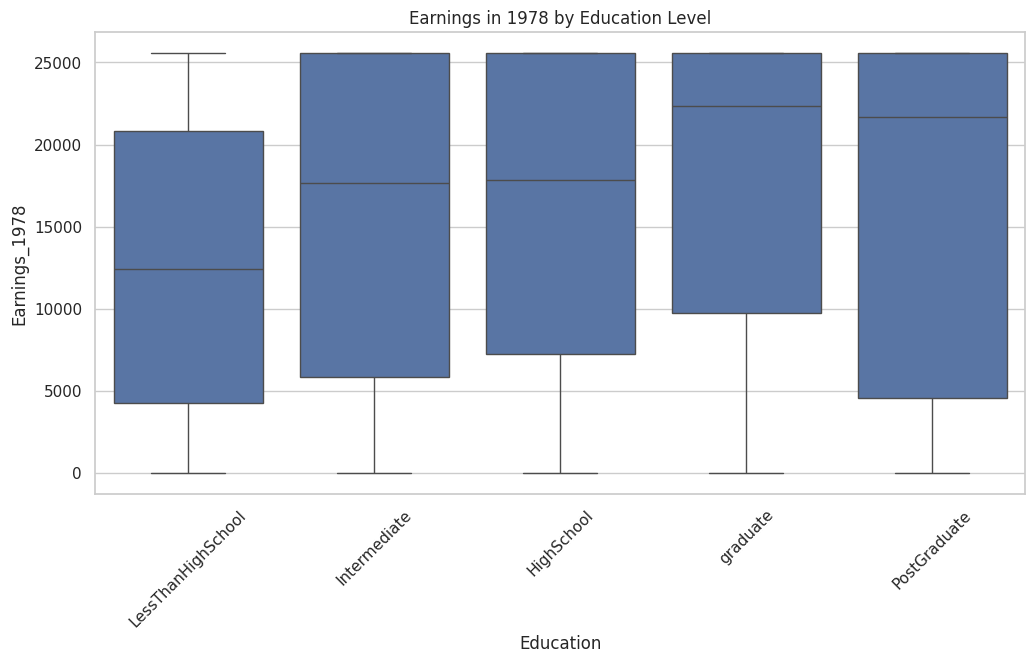

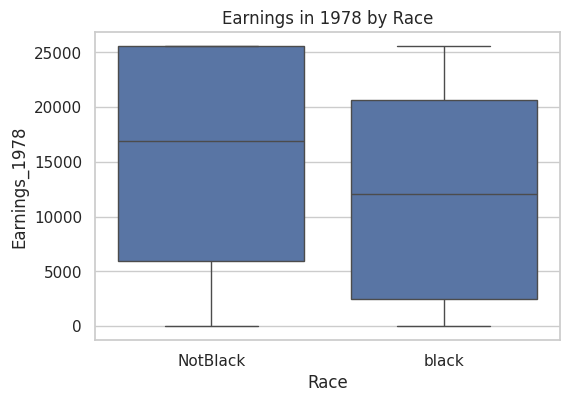

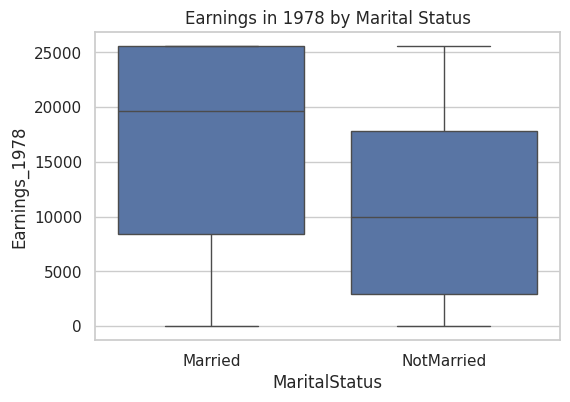

In [21]:
original_df = pd.read_csv('LabourTrainingData.csv')
original_df.rename(columns={"Eduacation": "Education"}, inplace=True)


plt.figure(figsize=(12, 6))
sns.boxplot(x='Education', y='Earnings_1978', data=original_df)
plt.xticks(rotation=45)
plt.title('Earnings in 1978 by Education Level')
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(x='Race', y='Earnings_1978', data=original_df)
plt.title('Earnings in 1978 by Race')
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(x='MaritalStatus', y='Earnings_1978', data=original_df)
plt.title('Earnings in 1978 by Marital Status')
plt.show()

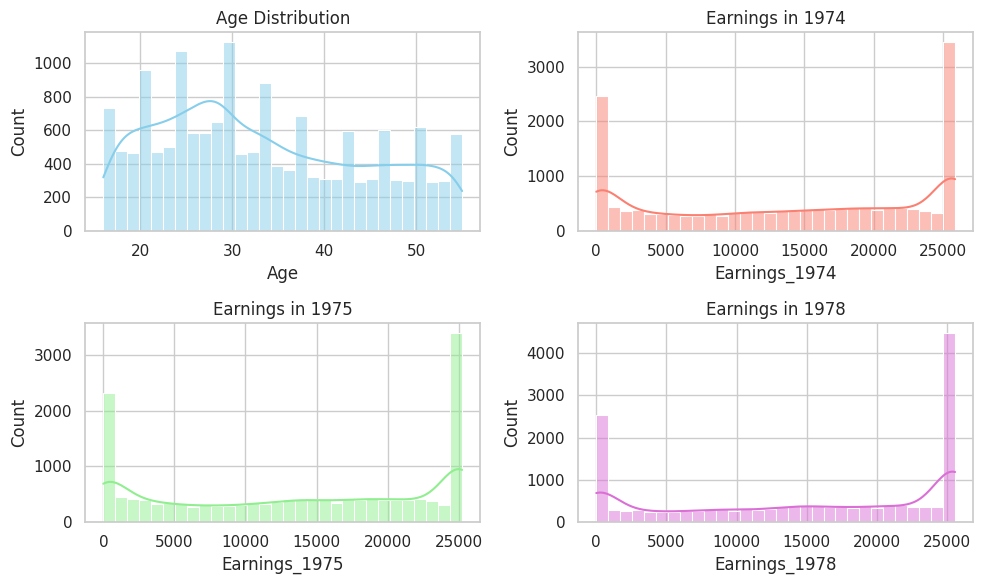

In [22]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(10, 6))

sns.histplot(df['Age'], kde=True, ax=axes[0, 0], bins=30, color='skyblue')
axes[0, 0].set_title("Age Distribution")

sns.histplot(df['Earnings_1974'], kde=True, ax=axes[0, 1], bins=30, color='salmon')
axes[0, 1].set_title("Earnings in 1974")

sns.histplot(df['Earnings_1975'], kde=True, ax=axes[1, 0], bins=30, color='lightgreen')
axes[1, 0].set_title("Earnings in 1975")

sns.histplot(df['Earnings_1978'], kde=True, ax=axes[1, 1], bins=30, color='orchid')
axes[1, 1].set_title("Earnings in 1978")

plt.tight_layout()
plt.show()


####1. Age

*   Distribution is roughly normal or bell-shaped, centered around 30–40 years.
*   Indicates most individuals are in their working-age range.
*   Few entries below 20 or above 60 suggest limited data for very young or older workers.
####2.Earning 1974
*   Skewed to the right (positive skew).
*   Many people earned less than ₹10,000, and only a few had high earnings (up to ₹60,000+).
*   This indicates income inequality or early career stage for most individuals.
####3. Earning 1975
*   Still positively skewed, but distribution shifts slightly higher than 1974.
*  Suggests a general increase in earnings year over year
####4. Earning 1978
*   More pronounced peak around ₹20,000–₹25,000.
*   Fewer low-income entries compared to previous years — implies economic improvement or experience gain.
*   Still some high earners that act as outliers.
















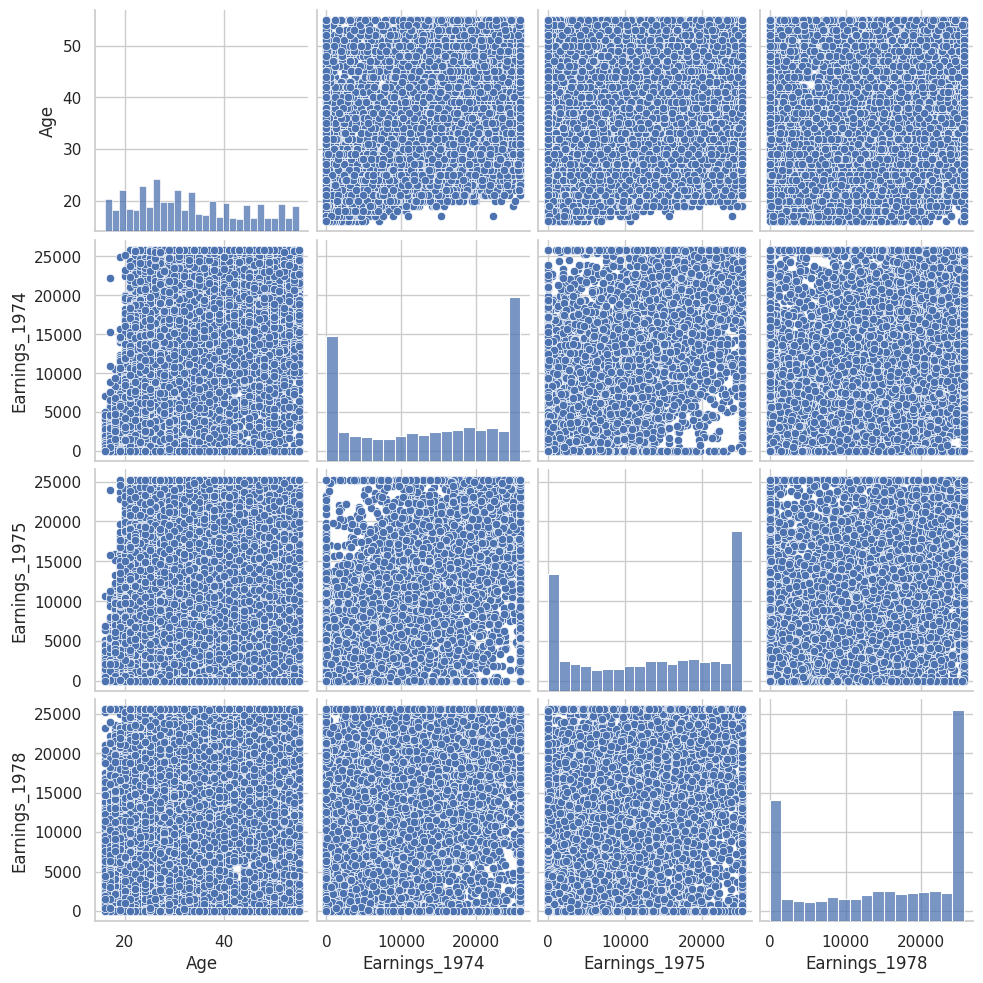

In [23]:
sns.pairplot(df[['Age', 'Earnings_1974', 'Earnings_1975', 'Earnings_1978']])
plt.show()

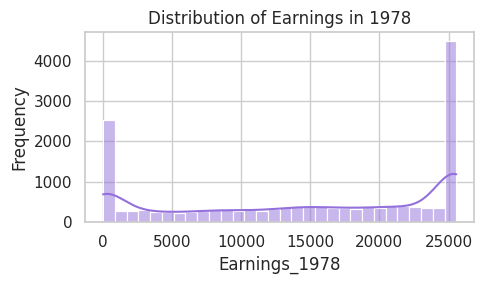

In [24]:
if 'Earnings_1978' in df.columns:
    plt.figure(figsize=(5,3))
    sns.histplot(df['Earnings_1978'], bins=30, kde=True, color='mediumpurple')
    plt.title("Distribution of Earnings in 1978")
    plt.xlabel("Earnings_1978")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

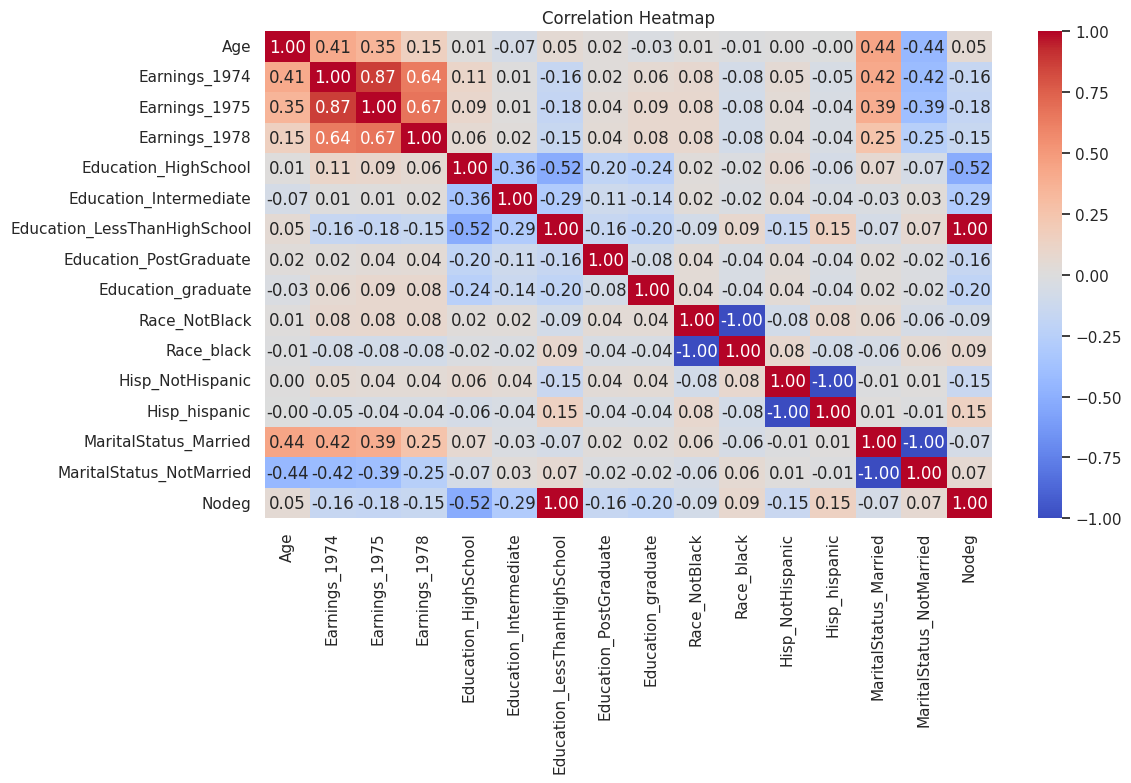

In [25]:
plt.figure(figsize=(12,8))
sns.heatmap(df1.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

### 1.Earnings_1974, Earnings_1975, and Earnings_1978 are highly correlated:


*   Earnings_1974 ↔ Earnings_1975: 0.87
*   Earnings_1975 ↔ Earnings_1978: 0.67

*  Earnings_1974 ↔ Earnings_1978: 0.64
#### Past earnings are strong predictors of future earnings — useful for regression modeling.
### 2. Age and Marital Status Impact Earnings
*   Age has moderate positive correlation with:
*  MaritalStatus_Married also positively correlates with earnings (e.g., 0.42 with Earnings_1974)


*  MaritalStatus_NotMarried has negative correlation with earnings
#### Older and married individuals tend to earn more, especially in earlier years.
### 3. Education Level and Earnings

*   Education_LessThanHighSchool is negatively correlated with earnings:
*  Nodeg also shows similar negative impact on earnings.
####  Lower education or no degree → lower earnings. The lack of a degree is a significant negative predictor.
### 4. Race and Ethnicity
*   Race_black ↔ Earnings: mostly between -0.08 to 0.00
*   Hisp_hispanic: close to zero

*  Race_black and Race_NotBlack are perfectly inversely correlated (-1.00), as expected (they're binary opposites)
#### Race and ethnicity in this dataset do not strongly influence earnings, though this may depend on other latent variables.
###  Individuals with no educational degree earn less across all years. This is a key risk factor.




















In [26]:
df1[['Age', 'Nodeg', 'Earnings_1974', 'Earnings_1975', 'Earnings_1978']].corr()


,Age,Nodeg,Earnings_1974,Earnings_1975,Earnings_1978
Age,1.000000,0.052376,0.407500,0.349839,0.154274
Nodeg,0.052376,1.000000,-0.163768,-0.176385,-0.151943
Earnings_1974,0.407500,-0.163768,1.000000,0.870181,0.639334
Earnings_1975,0.349839,-0.176385,0.870181,1.000000,0.668310
Earnings_1978,0.154274,-0.151943,0.639334,0.668310,1.000000


<Axes: xlabel='Earnings_Growth', ylabel='Count'>

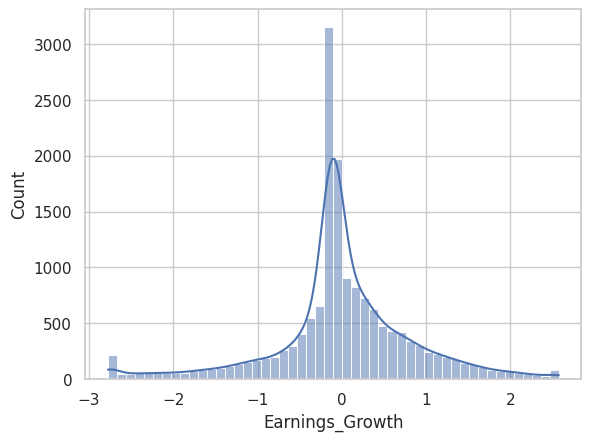

In [27]:
df1['Earnings_Growth'] = df1['Earnings_1978'] - df1['Earnings_1974']
sns.histplot(df1['Earnings_Growth'], bins=50, kde=True)


###1. High Peak at 0

*  The sharp spike around 0 means a large number of individuals had no significant change in their earnings between 1974 and 1978.
*   This could indicate wage stagnation, stable jobs, or possibly a cap in the earning scale
###2. Slight Right Skew

*   More individuals experienced positive growth (to the right of 0) than negative.
*   There is a long tail on the right, meaning some people had substantial wage increases.
###3. Few Negative Growth Outliers


*   The left tail shows that some people had large drops in income — could be job loss, career shift, etc.















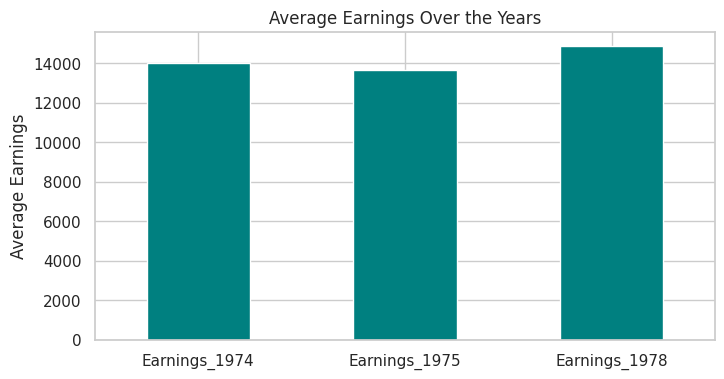

In [28]:
avg_earnings = df[['Earnings_1974', 'Earnings_1975', 'Earnings_1978']].mean()
plt.figure(figsize=(8, 4))
avg_earnings.plot(kind='bar', color='teal')
plt.title("Average Earnings Over the Years")
plt.ylabel("Average Earnings")
plt.xticks(rotation=0)
plt.show()


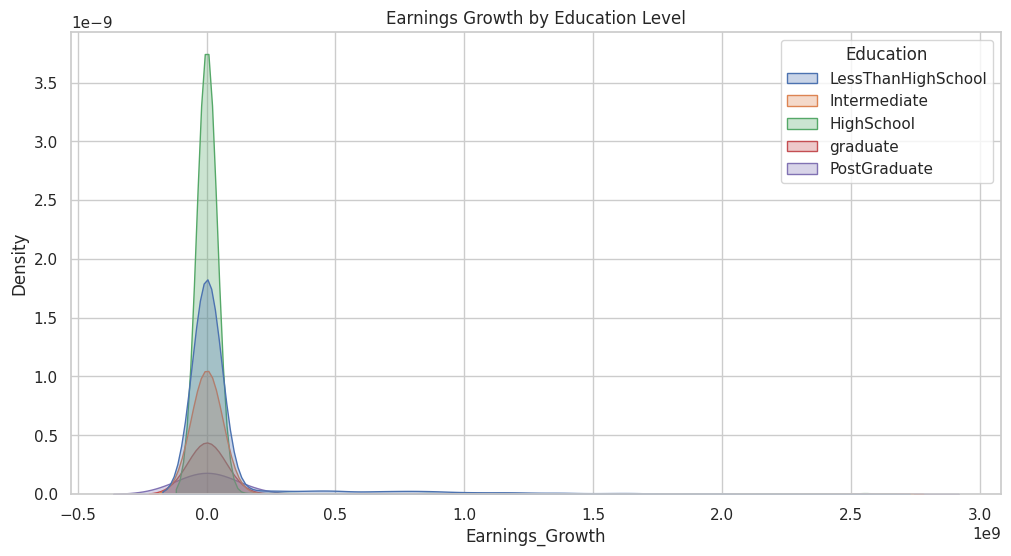

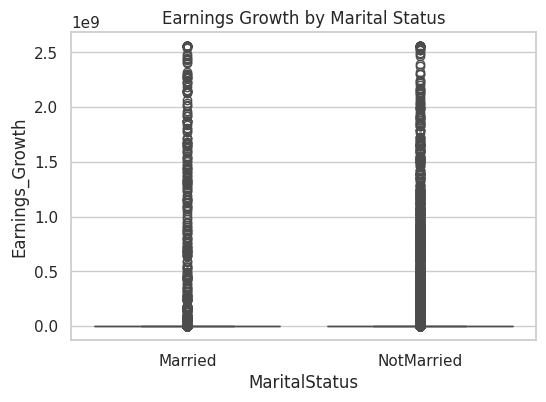

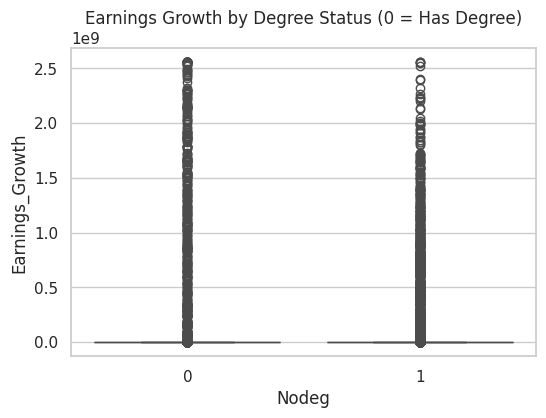

In [29]:
df['Earnings_Growth'] = (df['Earnings_1978'] - df['Earnings_1974']) / (df['Earnings_1974'] + 1e-5)

plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x='Earnings_Growth', hue='Education', fill=True, alpha=0.3)
plt.title("Earnings Growth by Education Level")
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='MaritalStatus', y='Earnings_Growth')
plt.title("Earnings Growth by Marital Status")
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='Nodeg', y='Earnings_Growth')
plt.title("Earnings Growth by Degree Status (0 = Has Degree)")
plt.show()


###1.Most Earnings Growth Peaks Are Near Zero


*    Suggests majority of individuals had little change in earnings, regardless of education level.

###2.PostGraduate and Graduate Tails Extend Farther Right

*  Indicates more high-income growth outliers among highly educated individuals.

###3.LessThanHighSchool Peaks Are Sharper and Narrower
*   Suggests that their earnings tend to cluster near zero, with fewer gains or losses.

###4.HighSchool and Intermediate Are More Symmetric
*   May indicate modest, predictable earnings trends without dramatic shifts.







##Useful Actions Based on This:


*   Target Upskilling for lower-education groups, who show limited income mobility
*  Use this distribution to cluster income trajectories and build profiles of economic growth.
*   Consider further breaking down by Race, Nodeg, or Training Status if available.





.





People with zero earnings in 1974: 1913
People with zero earnings in 1978: 2172


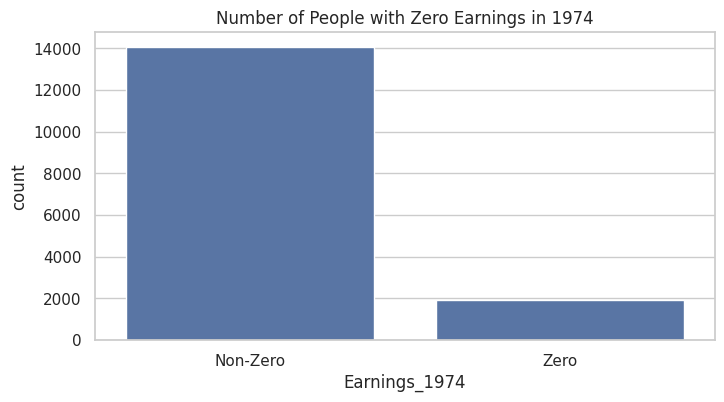

In [30]:
zero_1974 = df[df['Earnings_1974'] == 0]
zero_1978 = df[df['Earnings_1978'] == 0]

print(f"People with zero earnings in 1974: {len(zero_1974)}")
print(f"People with zero earnings in 1978: {len(zero_1978)}")

plt.figure(figsize=(8, 4))
sns.countplot(x=(df['Earnings_1974'] == 0).astype(int))
plt.title("Number of People with Zero Earnings in 1974")
plt.xticks([0, 1], ['Non-Zero', 'Zero'])
plt.show()


### 1. Majority Had Non-Zero Earnings

*   Over 14,000 individuals had non-zero income in 1974.
*  Indicates most people were employed or economically active.

###2. Significant Minority Had Zero Earnings

*   Close to 2,000 individuals had zero earnings.
*   This is a non-negligible 12.5% of the population.






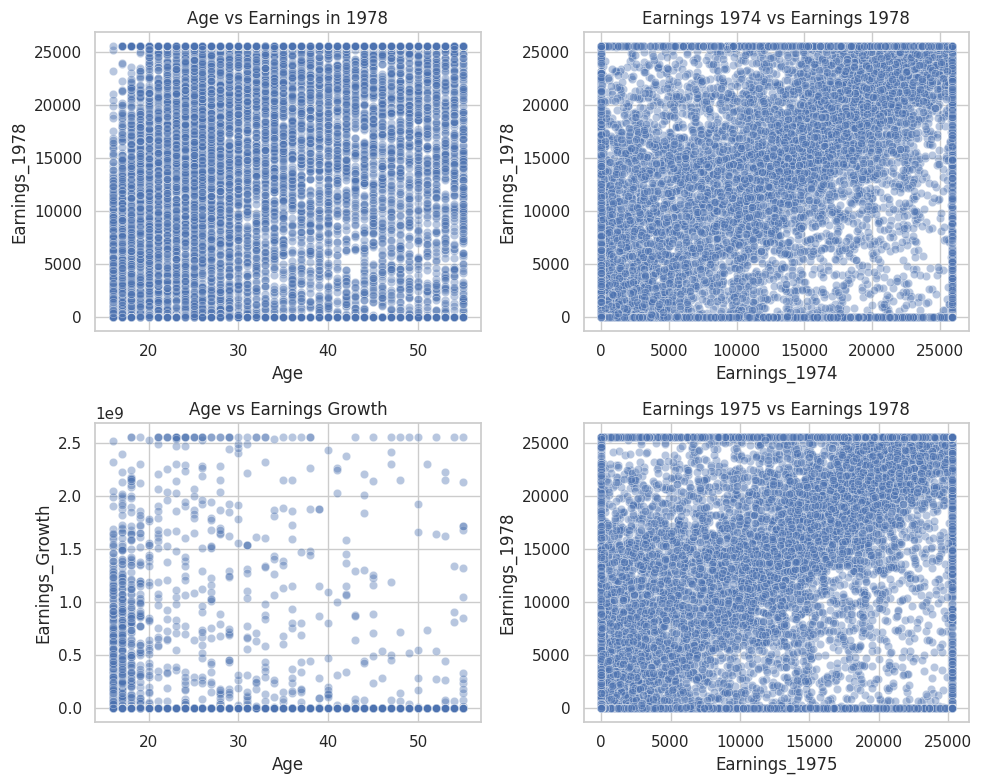

In [31]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

sns.scatterplot(x='Age', y='Earnings_1978', data=df, ax=axes[0, 0], alpha=0.4)
axes[0, 0].set_title("Age vs Earnings in 1978")

sns.scatterplot(x='Earnings_1974', y='Earnings_1978', data=df, ax=axes[0, 1], alpha=0.4)
axes[0, 1].set_title("Earnings 1974 vs Earnings 1978")

sns.scatterplot(x='Age', y='Earnings_Growth', data=df, ax=axes[1, 0], alpha=0.4)
axes[1, 0].set_title("Age vs Earnings Growth")

sns.scatterplot(x='Earnings_1975', y='Earnings_1978', data=df, ax=axes[1, 1], alpha=0.4)
axes[1, 1].set_title("Earnings 1975 vs Earnings 1978")

plt.tight_layout()
plt.show()


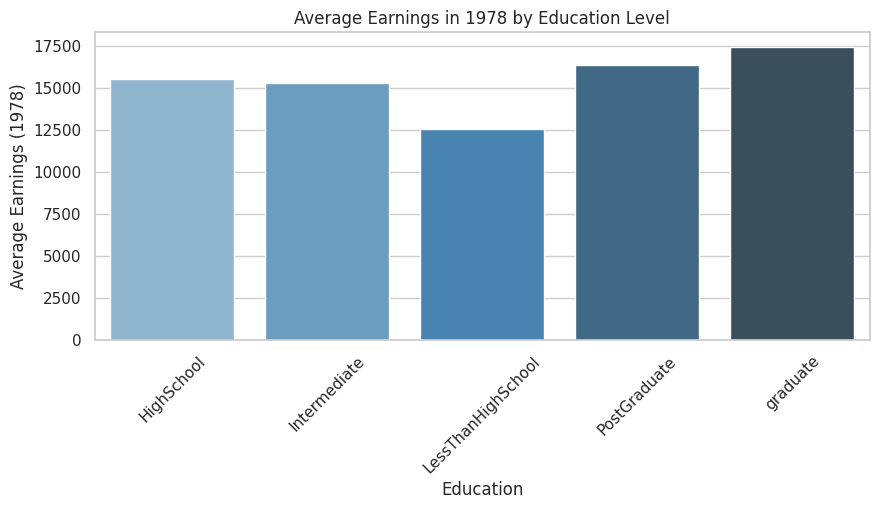

In [40]:
edu_avg_earnings = original_df.groupby('Education')['Earnings_1978'].mean()
edu_df = edu_avg_earnings.reset_index()
plt.figure(figsize=(10, 4))
sns.barplot(data=edu_df, x='Education', y='Earnings_1978', hue='Education', palette="Blues_d", dodge=False, legend=False)
plt.title("Average Earnings in 1978 by Education Level")
plt.ylabel("Average Earnings (1978)")
plt.xticks(rotation=45)
plt.show()



*   Higher education levels consistently correspond with higher average earnings in 1978.


*   Individuals with graduate degrees had the highest earnings, while those with less than high school had the lowest.



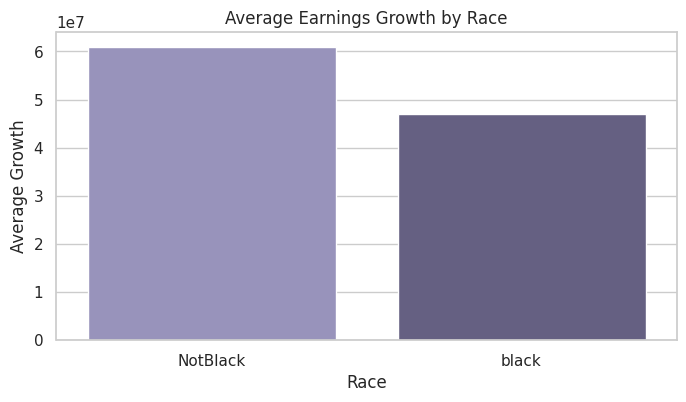

In [36]:
race_df = race_avg_growth.reset_index()
plt.figure(figsize=(8, 4))
sns.barplot(data=race_df, x='Race', y='Earnings_Growth', hue='Race', palette="Purples_d", dodge=False, legend=False)
plt.title("Average Earnings Growth by Race")
plt.ylabel("Average Growth")
plt.show()



*   People identified as "NotBlack" experienced significantly higher average earnings growth compared to those identified as "black".


*   This indicates a disparity in income growth across racial groups.



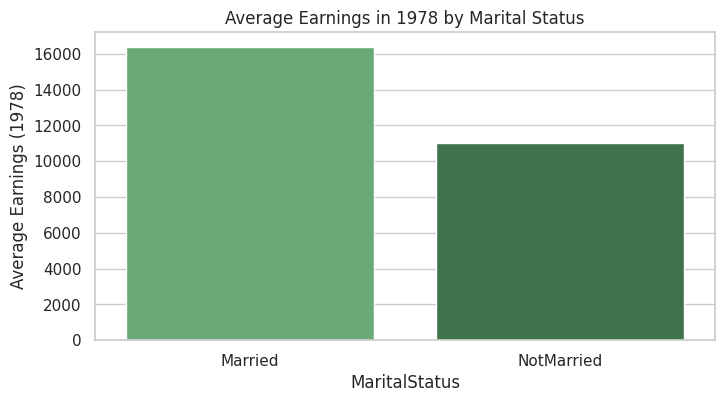

In [39]:
marital_df = marital_avg_earnings.reset_index()
plt.figure(figsize=(8, 4))
sns.barplot(data=marital_df, x='MaritalStatus', y='Earnings_1978', hue='MaritalStatus',
            palette="Greens_d", dodge=False, legend=False)
plt.title("Average Earnings in 1978 by Marital Status")
plt.ylabel("Average Earnings (1978)")
plt.show()



*   Married individuals had significantly higher average earnings in 1978 than those who were not married.


*   Marital status appears to correlate positively with income level.



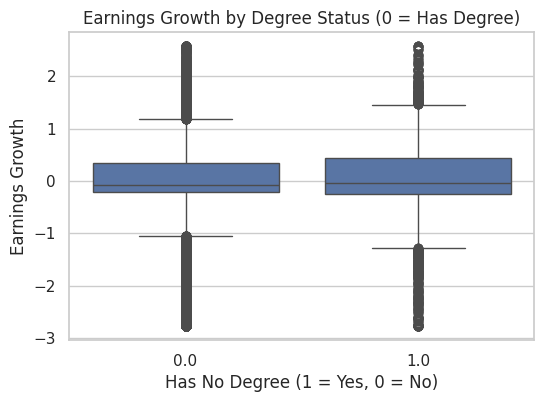

In [ ]:
-plt.figure(figsize=(6, 4))
sns.boxplot(data=df1, x='Nodeg', y='Earnings_Growth')
plt.title("Earnings Growth by Degree Status (0 = Has Degree)")
plt.xlabel("Has No Degree (1 = Yes, 0 = No)")
plt.ylabel("Earnings Growth")
plt.show()




*   Individuals with and without degrees show similar median earnings growth, but degree holders show slightly more variability and higher upper-end growth.


*   A degree doesn't guarantee higher growth, but it may offer more potential for higher earnings.



### 5. Model Training

In [41]:
X = df.drop(columns=['Earnings_1978'])
y = df['Earnings_1978']

In [43]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(processed_data, y, test_size=0.2, random_state=42)

In [45]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### 6. Modal Evaluation

In [53]:
y_pred = model.predict(X_test)
print("R2 Score:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

R2 Score: 0.9999999478125307
RMSE: 4.849458405821711
MAE: 1.2653623893029282


#### Accuracy of this model is 99.9%

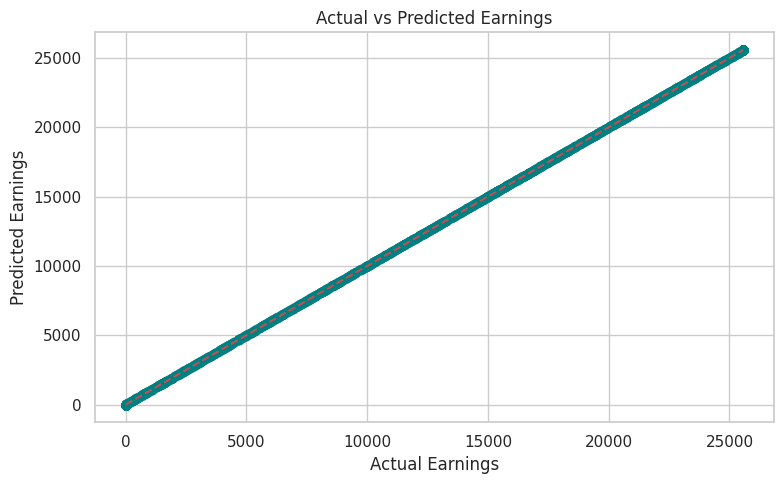

In [51]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.6, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line y=x
plt.xlabel("Actual Earnings")
plt.ylabel("Predicted Earnings")
plt.title("Actual vs Predicted Earnings")
plt.tight_layout()
plt.show()
